## Librairies + importation

In [215]:
# import sys
# sys.path.append('C:\\Users\\l.boisson\\AppData\\Local\\mambaforge\\lib\\site-packages')

from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import xarray as xr
import feather
import csv
import re
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain, product, pairwise
from more_itertools import consecutive_groups

import configparser
import tkinter as tk
from tkinter import filedialog

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [216]:
# crée une instance GUI
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

path_export = Data_Path.as_posix() + '/Exports/'
if not os.path.exists(path_export):
    os.makedirs(path_export)

## Définition des fonctions

In [217]:
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }


## Extraction données data pour calcul montée en force

In [218]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("Manips_test/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["ISO"]:
            skiprows = 151
        else:
            skiprows = 210
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "condition", "contraction", "essai", "mesure"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)
# df_column.set_index(["participant", "groupe", "condition", "contraction", "essai", "Frame"], inplace=True)

df_column

C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_CON60_1_11.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_EXC_1.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_2_02.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_H_EXC_5.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_H_ISO_2_21.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\002_CTRL_CON60_1_02.cxp


,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time
0,-3.897,14.841,-76.568,001,CH,CON60,1,11,1,0.003906
1,-4.141,15.231,-76.508,001,CH,CON60,1,11,2,0.007812
2,-4.386,15.622,-76.447,001,CH,CON60,1,11,3,0.011719
3,-3.897,14.841,-76.389,001,CH,CON60,1,11,4,0.015625
4,-4.141,14.450,-76.333,001,CH,CON60,1,11,5,0.019531
...,...,...,...,...,...,...,...,...,...,...
30114,0.801,0.000,-90.137,002,CTRL,CON60,1,02,4138,16.164062
30115,0.801,0.391,-90.136,002,CTRL,CON60,1,02,4139,16.167969
30116,0.069,0.000,-90.136,002,CTRL,CON60,1,02,4140,16.171875
30117,0.801,-0.391,-90.137,002,CTRL,CON60,1,02,4141,16.175781


<AxesSubplot: xlabel='Time', ylabel='Force'>

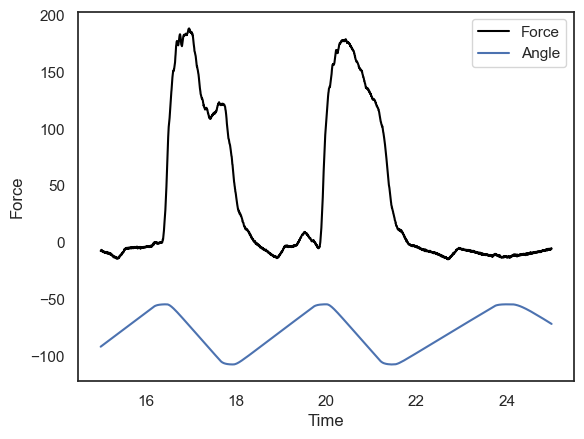

In [249]:
test = df_column[
    (df_column['participant'] == '001') &
    (df_column['condition'] == 'CH') &
    (df_column['contraction'] == 'EXC')
    & (df_column.Time > 15)
    & (df_column.Time < 25)
]

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Force',
    label="Force",
    c = 'black'
    )

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Angle',
    label="Angle"
    )

In [220]:
def drop_last_0_5sec(df):
    df = df.iloc[:-10]
    return df
    
df_column = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure'], group_keys=False).apply(drop_last_0_5sec)

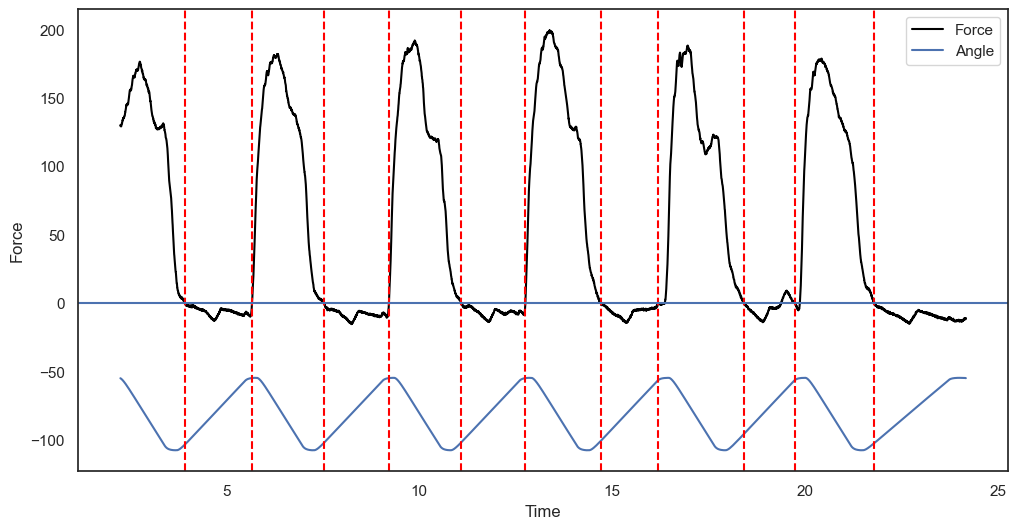

In [243]:
test = df_column[
    (df_column['participant'] == '001') &
    (df_column['condition'] == 'CH') &
    (df_column['contraction'] == 'EXC')
                        #   (df_emg_rms['Time'] > 4) & (df_emg_rms['Time'] < 12) & 
]

data_max_ev = test[np.isclose(test['Angle'],test['Angle'].max(),0.005)]
data_min_ev = test[np.isclose(test['Angle'],test['Angle'].min(),0.005)]

start_flexion = []
start_extension = []

for group in consecutive_groups(data_max_ev.Frame):
    # print(list(group)[-1])
    start_flexion.append(list(group)[-1])

for group in consecutive_groups(data_min_ev.Frame):
    # test3 = test[test.index > first_value]
    start_extension.append(list(group)[-1])
    
test = test.assign(mouvement=['Extension']*len(test))
# for a, b in zip(start_flexion,start_extension):
#     # print(a)
#     test.loc[(test.Frame > a) & (test.Frame < b),'mouvement'] = 'Eversion'
test = test[(test.Frame > start_flexion[0]) &
            (test.Frame < start_flexion[-1])]

positive = test.Force.values > 0
zero_crossing = np.where(np.bitwise_xor(positive[1:],positive[:-1]))[0] + test.index[0]
angle_change = start_flexion + start_extension
tolerance = 150
filtered_zero_crossing = []
angle_change.sort()
# zero_crossing = zero_crossing[4:]
for point in angle_change:
    test2 = zero_crossing[np.isclose(point,test[test.index.isin(zero_crossing)].Frame, atol = tolerance)]
    if len(test2) > 1:
        test2 = [min(test2)]
    if len(test2) != 0:
        filtered_zero_crossing.extend(test2)
        
# test = test[(test.index > zero_crossing[0]) &
#             (test.index < zero_crossing[-2])]
# current_state = 'Eversion'
# zero_crossing = np.concatenate([zero_crossing[0],zero_crossing[3:]])    

# # Iterate over pairs
# for start, end in pairwise(zero_crossing):
#     test.loc[(test.index >= start) & (test.index <= end), 'mouvement'] = current_state
    
#     # Switch between 'Eversion' and 'Inversion'
#     current_state = 'Inversion' if current_state == 'Eversion' else 'Eversion'
# data_plot = test[(test['Time'] > 0) & (test['Time'] < 60)].set_index('Time')
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Force',
    label="Force",
    c = 'black'
    )

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Angle',
    label="Angle"
    )

for timestamp in filtered_zero_crossing:
    ax.axvline(x=test.loc[timestamp,'Time'], color='red', linestyle='dashed')    
ax.axhline(0)

In [244]:
test2

array([], dtype=int64)

In [250]:
def detection_sens_mouvement(grp):
    print(grp.name)
    
    if grp.contraction.unique() == 'ISO':
        grp = grp.assign(mouvement=['Iso']*len(grp),
                         repetition=1)
        
        return grp
    
    data_max_flexion = grp[np.isclose(grp['Angle'],grp['Angle'].max(),0.005)]
    data_min_flexion = grp[np.isclose(grp['Angle'],grp['Angle'].min(),0.005)]
    
    # print(grp[np.isclose(grp['Angle'],grp['Angle'].max(),0.005)])
    
    start_flexion = []
    start_extension = []
 
    for group in consecutive_groups(data_max_flexion.Frame):
        start_flexion.append(list(group)[-1]) #f

    for group in consecutive_groups(data_min_flexion.Frame):
        start_extension.append(list(group)[-1]) #e

    angle_change = start_flexion + start_extension

    if grp.contraction.unique() == 'EXC':
        grp = grp.assign(mouvement=['Extension']*len(grp))
    else:
        grp = grp.assign(mouvement=['Flexion']*len(grp))
        
    grp = grp[(grp.Frame > start_flexion[0]) & (grp.Frame < start_extension[-1])]

    positive = grp.Force.values > 0
    zero_crossing = np.where(np.bitwise_xor(positive[1:],positive[:-1]))[0] + grp.index[0]    

    tolerance = 150
    filtered_zero_crossing = []
    angle_change.sort()
    for point in angle_change:
        test2 = zero_crossing[np.isclose(point,grp[grp.index.isin(zero_crossing)].Frame, atol = tolerance)]
        if len(test2) > 1:
            test2 = [min(test2)]
        if len(test2) != 0:
            filtered_zero_crossing.extend(test2)
            
                                                               
    if len(filtered_zero_crossing) > 12:
        filtered_zero_crossing = filtered_zero_crossing[:12]
                            
    grp = grp[(grp.index > filtered_zero_crossing[0]) &
                (grp.index < filtered_zero_crossing[-1])]
          
    if grp.contraction.unique() == 'EXC':
        current_state = 'Extension'
        nrep = 1
        # Iterate over pairs
        for start, end in pairwise(filtered_zero_crossing):
            grp.loc[(grp.index >= start) & (grp.index <= end), 'mouvement'] = current_state
            grp.loc[(grp.index >= start) & (grp.index <= end), 'repetition'] = nrep
            # Switch between 'Eversion' and 'Inversion'
            current_state = 'Flexion' if current_state == 'Extension' else 'Extension'
            if current_state == 'Extension':
                nrep += 1
    else:
        # Initialize the state variable
        current_state = 'Flexion'
        nrep = 1
        # Iterate over pairs
        for start, end in pairwise(filtered_zero_crossing):
            grp.loc[(grp.index >= start) & (grp.index <= end), 'mouvement'] = current_state
            grp.loc[(grp.index >= start) & (grp.index <= end), 'repetition'] = nrep
            # Switch between 'Eversion' and 'Inversion'
            current_state = 'Extension' if current_state == 'Flexion' else 'Flexion'
            if current_state == 'Flexion':
                nrep += 1        
    return grp

df_force_phase = df_column.groupby(['participant','condition','contraction','essai', 'mesure'], group_keys=False).apply(detection_sens_mouvement)
df_force_phase

('001', 'CH', 'CON60', '1', '11')
('001', 'CH', 'EXC', '1', 0)
('001', 'CH', 'ISO', '2', '02')
('001', 'H', 'EXC', '5', 0)
('001', 'H', 'ISO', '2', '21')
('002', 'CTRL', 'CON60', '1', '02')


,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time,mouvement,repetition
615,0.009,-59.753,-86.516,001,CH,CON60,1,11,616,2.406250,Flexion,1.0
616,0.153,-60.534,-86.752,001,CH,CON60,1,11,617,2.410156,Flexion,1.0
617,0.053,-60.534,-86.989,001,CH,CON60,1,11,618,2.414062,Extension,1.0
618,-0.097,-59.753,-87.222,001,CH,CON60,1,11,619,2.417969,Extension,1.0
619,-0.197,-59.753,-87.455,001,CH,CON60,1,11,620,2.421875,Extension,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29014,-0.667,-60.143,-93.172,002,CTRL,CON60,1,02,3038,11.867188,Extension,3.0
29015,-0.453,-59.753,-93.405,002,CTRL,CON60,1,02,3039,11.871094,Extension,3.0
29016,0.016,-59.753,-93.638,002,CTRL,CON60,1,02,3040,11.875000,Extension,3.0
29017,-0.493,-60.143,-93.873,002,CTRL,CON60,1,02,3041,11.878906,Extension,3.0


In [223]:
# def reset_time(df):
#     print(df.name)
#     df = df[df.Force < -1.5]
#     df.Time -= df.Time.values[0]
#     return df

# df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'repetition'], group_keys=False).apply(reset_time)
# df_force_phase

('001', 'CH', 'CON60', '1', '11', 1.0)
('001', 'CH', 'CON60', '1', '11', 2.0)
('001', 'CH', 'CON60', '1', '11', 3.0)
('001', 'CH', 'CON60', '1', '11', 4.0)
('001', 'CH', 'EXC', '1', 0, 1.0)
('001', 'CH', 'EXC', '1', 0, 2.0)
('001', 'CH', 'EXC', '1', 0, 3.0)
('001', 'CH', 'EXC', '1', 0, 4.0)
('001', 'CH', 'EXC', '1', 0, 5.0)
('001', 'CH', 'ISO', '2', '02', 1.0)
('001', 'H', 'EXC', '5', 0, 1.0)
('001', 'H', 'EXC', '5', 0, 2.0)
('001', 'H', 'EXC', '5', 0, 3.0)
('001', 'H', 'EXC', '5', 0, 4.0)
('001', 'H', 'EXC', '5', 0, 5.0)
('001', 'H', 'ISO', '2', '21', 1.0)
('002', 'CTRL', 'CON60', '1', '02', 1.0)
('002', 'CTRL', 'CON60', '1', '02', 2.0)
('002', 'CTRL', 'CON60', '1', '02', 3.0)


,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time,mouvement,repetition
626,-1.829,-59.362,-89.092,001,CH,CON60,1,11,627,0.000000,Extension,1.0
638,-1.714,-59.753,-91.904,001,CH,CON60,1,11,639,0.046875,Extension,1.0
641,-1.646,-60.143,-92.607,001,CH,CON60,1,11,642,0.058594,Extension,1.0
645,-1.882,-60.143,-93.544,001,CH,CON60,1,11,646,0.074219,Extension,1.0
649,-1.988,-60.143,-94.481,001,CH,CON60,1,11,650,0.089844,Extension,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
28984,-2.357,-59.362,-86.145,002,CTRL,CON60,1,02,3008,2.425781,Extension,3.0
28985,-1.848,-60.143,-86.380,002,CTRL,CON60,1,02,3009,2.429688,Extension,3.0
28986,-1.574,-59.753,-86.613,002,CTRL,CON60,1,02,3010,2.433594,Extension,3.0
28989,-1.504,-60.534,-87.318,002,CTRL,CON60,1,02,3013,2.445312,Extension,3.0


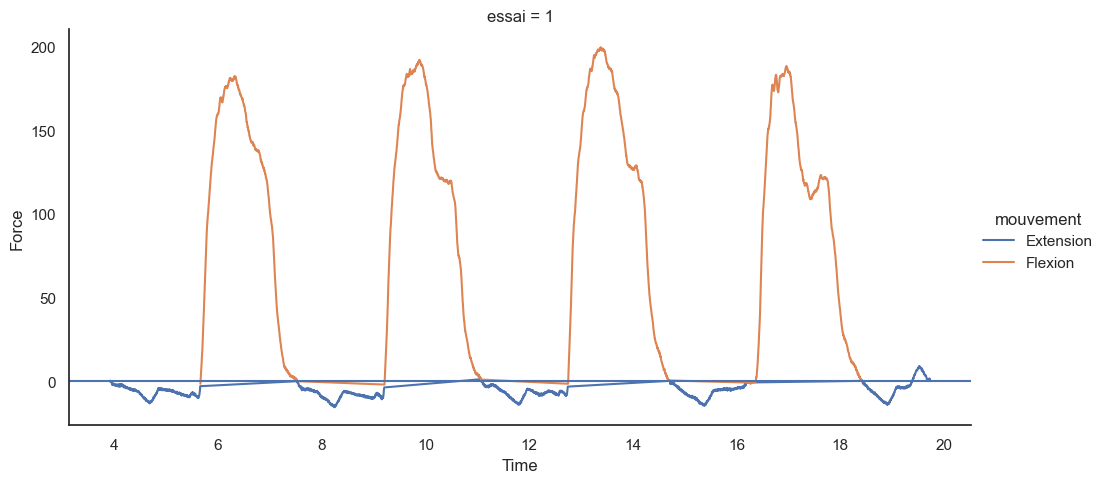

In [251]:
data_plot = df_force_phase[
    (df_force_phase['participant'] == '001') &
    (df_force_phase['condition'] == 'CH') &
    (df_force_phase['contraction'] == 'EXC') 
    # &(df_force_phase['mouvement'] == 'Extension')
]


sns.relplot(data_plot, 
            x= 'Time',
             y = 'Force',
             hue= 'mouvement',
             kind = 'line', 
             aspect= 2,
             col = 'essai',
             facet_kws=dict(sharex=False)
             )

plt.axhline(0)
# plt.axvline(4.5)